### Minimal Manipulation to Get a Machine Learning Pipeline Running

Notebook inspired by: https://civisanalytics.com/blog/data-science/2015/12/17/workflows-in-python-getting-data-ready-to-build-models/

Data source: https://www.drivendata.org/competitions/7/page/25/

<ol>
<li>Load the features and label data *.csv files as pandas dataframes</li>
<li>Map target label from string to int</li>
<li>steps</li>
</ol>

Load data as dataframes

In [14]:
import pandas as pd
import numpy as np

features_df = pd.DataFrame.from_csv("well_data.csv")   # features data
labels_df   = pd.DataFrame.from_csv("well_labels.csv") # labels
print( labels_df.head(4) )

         status_group
id                   
69572      functional
8776       functional
34310      functional
67743  non functional


There are three target well labels in the data
<ol>
<li>functional</li>
<li>non functional</li>
<li>functional needs repair</li>
</ol>

In [15]:
for x in labels_df['status_group'].unique():  #list all the unique entries of the labels
    print (x)

functional
non functional
functional needs repair


The target variable must be mapped from string labels to integers (a scikit learn requirement), e.g. 'functional' maps to 2 

In [16]:
#function to map the labels from string to ints
#read a string and maps it to one of three integer values 0, 1 & 2
def label_map(y):
   if y=="functional":
       return 2
   elif y=="functional needs repair":
       return 1
   else:
       return 0
labels_df = labels_df.applymap(label_map) # map labels

#test
print( labels_df.head() )

       status_group
id                 
69572             2
8776              2
34310             2
67743             0
19728             2


In [17]:
# Check that the labels have been encoded to ints 0,1,2
for x in labels_df['status_group'].unique():
    print (x)

2
0
1


Check the distribution of the targets - the sub populations are varied

status_group
0    22824
1     4317
2    32259
dtype: int64


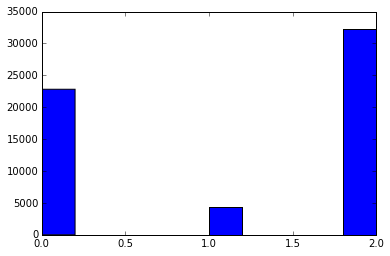

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(labels_df['status_group'])
print(labels_df.groupby('status_group').size())

Peek at the features data frame, they are a mix of categorical and non categorical data

In [6]:
features_df.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


There are categorical variables in the dataset but on a first pass, only look at the continous variables

In [24]:
features_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [38]:
#features_df.columns.map(lambda x: print(x)) # one way of printing the list of features line by line
#features_df.columns

In [27]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(features_df.dtypes[features_df.dtypes != "object"].index)
features_df[numeric_variables].head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
69572,6000,1390,34.938093,-9.856322,0,11,5,109,1999
8776,0,1399,34.698766,-2.147466,0,20,2,280,2010
34310,25,686,37.460664,-3.821329,0,21,4,250,2009
67743,0,263,38.486161,-11.155298,0,90,63,58,1986
19728,0,0,31.130847,-1.825359,0,18,1,0,0


### Run Bare Metal Random Forest Classifier with Continuous Variables Only

In [41]:
# Continuous Data for bare metal ML
X_numeric = features_df[numeric_variables]
y = labels_df['status_group'].tolist()

In [42]:
import sklearn
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
score = sklearn.cross_validation.cross_val_score( clf, X_numeric, y )
print( score )

[ 0.71479798  0.7180303   0.70858586]


### Stratified Shuffle Split Sample
Prepare stratified, shuffled and split data for the pipeline

In [57]:
from sklearn.cross_validation import StratifiedShuffleSplit
test_proportion = 0.2 # proportion of data to be held out for testing
seed = 42 # random state seed
numtests = 1 # number of split sets to generate
sss = StratifiedShuffleSplit(y,numtests, test_size=test_proportion, random_state=seed)
for train_index, test_index in sss:
    print("TRAIN indices:", train_index, "TEST indices:", test_index)

TRAIN indices: [56033 42149 50644 ..., 23965 52811 37112] TEST indices: [52237  4107 28169 ..., 54782  2110  3833]


How the train and test data have been split

In [45]:
print(len(train_index))
print(len(test_index))
print(len(train_index) + len(test_index))

47520
11880
59400


Create the stratified training and testing data

In [58]:
X_numeric_train = X_numeric.iloc[train_index,]
X_numeric_test = X_numeric.iloc[test_index,]
y_test = labels_df.iloc[test_index] # iloc does not give those spurious NaNs
y_test = y_test['status_group'].tolist()
y_train = labels_df.iloc[train_index]
y_train = y_train['status_group'].tolist()

### Setup Basic Pipeline

In [52]:
import sklearn.pipeline
steps = [('random_forest', clf)] 
pipeline = sklearn.pipeline.Pipeline(steps) ## Instantiate the pipeline
clf = sklearn.ensemble.RandomForestClassifier()

### Setup Grid Search & Run the Algo

In [56]:
import sklearn.grid_search

parameters = dict(random_forest__min_samples_split=[5, 10], # [2, 3, 4, 5, 10]
              random_forest__min_samples_leaf = [5, 10],
              random_forest__n_estimators = [100, 200]) # the number of trees

cv = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_numeric_train, y_train)
y_predictions = cv.predict(X_numeric_test)
report = sklearn.metrics.classification_report( y_test, y_predictions )
print(report)

             precision    recall  f1-score   support

          0       0.73      0.67      0.70      4565
          1       0.67      0.19      0.30       863
          2       0.73      0.85      0.78      6452

avg / total       0.73      0.73      0.72     11880



With the minimal model completed we managed f1-score of 0.72, can move to model the data with the categorical data included

### Encode the categorical features and use them

In [59]:
# This transforms the categorical features into ints
# NOTE: This is NOT one-hot-encoding
def transform_feature( df, column_name ):
    
    unique_values = set( df[column_name].tolist() ) # find unique entries in column
    # init dict & populate dic, assign int to each elem in unique_values
    transformer_dict = {}
    for ii, value in enumerate(unique_values):
        transformer_dict[value] = ii

    def label_map(y):
        return transformer_dict[y]
    df[column_name] = df[column_name].apply( label_map )
    return df

### list of column names indicating which columns to transform; 
### this is just a start!  Use some of the print( labels_df.head() )
### output upstream to help you decide which columns get the
### transformation
names_of_columns_to_transform = ["funder", "installer", "wpt_name", "basin", "subvillage",
                    "region", "lga", "ward", "public_meeting", "recorded_by",
                    "scheme_management", "scheme_name", "permit",
                    "extraction_type", "extraction_type_group",
                    "extraction_type_class",
                    "management", "management_group",
                    "payment", "payment_type",
                    "water_quality", "quality_group", "quantity", "quantity_group",
                    "source", "source_type", "source_class",
                    "waterpoint_type", "waterpoint_type_group"]
for column in names_of_columns_to_transform:
    features_df = transform_feature( features_df, column )
    
#print( features_df.head() )

In [60]:
### remove the "date_recorded" column--we're not going to make use
### of time-series data today
features_df.drop("date_recorded", axis=1, inplace=True)
print(features_df.columns.values)

['amount_tsh' 'funder' 'gps_height' 'installer' 'longitude' 'latitude'
 'wpt_name' 'num_private' 'basin' 'subvillage' 'region' 'region_code'
 'district_code' 'lga' 'ward' 'population' 'public_meeting' 'recorded_by'
 'scheme_management' 'scheme_name' 'permit' 'construction_year'
 'extraction_type' 'extraction_type_group' 'extraction_type_class'
 'management' 'management_group' 'payment' 'payment_type' 'water_quality'
 'quality_group' 'quantity' 'quantity_group' 'source' 'source_type'
 'source_class' 'waterpoint_type' 'waterpoint_type_group']


In [61]:
features_df.head(3)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,1756,1390,1988,34.938093,-9.856322,35729,0,4,7450,...,6,3,0,4,4,8,5,1,0,0
8776,0,618,1399,1202,34.698766,-2.147466,32750,0,8,15021,...,3,3,0,3,3,6,4,2,0,0
34310,25,1147,686,138,37.460664,-3.821329,19827,0,6,1702,...,2,3,0,4,4,2,2,2,1,0


In [62]:
# The features and labels are taken out of their dataframe
# and put into a numpy.ndarray and list, respectively.
X = features_df.as_matrix()
y = labels_df["status_group"].tolist()

In [63]:
# logistic regression
import sklearn.linear_model
import sklearn.cross_validation

clf = sklearn.linear_model.LogisticRegression()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )


[ 0.67651515  0.67469697  0.67590909]


In [64]:
# random forest
import sklearn.tree
import sklearn.ensemble

clf = sklearn.tree.DecisionTreeClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )

[ 0.73979798  0.74070707  0.73712121]


In [65]:
clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )

[ 0.78686869  0.78914141  0.78757576]


In [66]:
#col = features_df.payment_type.tolist()
#col = np.reshape( col, (len(col), 1) )
#type(col)
#import sklearn.preprocessing
#enc = sklearn.preprocessing.OneHotEncoder()
#enc.fit(col)

In [67]:
# NOTE: OHE Only takes integers as input
# 'The input to this transformer should be a matrix of integers' - from:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# one-hot-encoder function that takes the data frame and the title of a column
# and returns the same data frame but one-hot encoding performed on the indicated feature.
# using the scikit-learn OneHotEncoder object, but pandas also has a function called get_dummies()
#that does effectively the same thing. In fact, I find get_dummies() easier to use in many cases,
#but I still find it worthwhile to see a more “manual” version of the transformation at least once.
import sklearn.preprocessing

def hot_encoder(df, column_name):
    column = df[column_name].tolist()
    column = np.reshape( column, (len(column), 1) )  ### needs to be an N x 1 numpy array
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit( column )
    new_column = enc.transform( column ).toarray()
    column_titles = []
    ### making titles for the new columns, and appending them to dataframe
    for ii in range( len(new_column[0]) ):
        this_column_name = column_name+"_"+str(ii)
        df[this_column_name] = new_column[:,ii]
    return df

In [68]:
print(features_df.columns.values)

# drop columns that blows up the number of features
features_df.drop( "funder", axis=1, inplace=True )
features_df.drop( "installer", axis=1, inplace=True )
features_df.drop( "wpt_name", axis=1, inplace=True )
features_df.drop( "subvillage", axis=1, inplace=True )
features_df.drop( "ward", axis=1, inplace=True )

names_of_columns_to_transform.remove("funder")
names_of_columns_to_transform.remove("installer")
names_of_columns_to_transform.remove("wpt_name")
names_of_columns_to_transform.remove("subvillage")
names_of_columns_to_transform.remove("ward")

# perform OHE for columns of interest that needs to be transformed
for feature in names_of_columns_to_transform:
    features_df = hot_encoder( features_df, feature )

features_df.head()

['amount_tsh' 'funder' 'gps_height' 'installer' 'longitude' 'latitude'
 'wpt_name' 'num_private' 'basin' 'subvillage' 'region' 'region_code'
 'district_code' 'lga' 'ward' 'population' 'public_meeting' 'recorded_by'
 'scheme_management' 'scheme_name' 'permit' 'construction_year'
 'extraction_type' 'extraction_type_group' 'extraction_type_class'
 'management' 'management_group' 'payment' 'payment_type' 'water_quality'
 'quality_group' 'quantity' 'quantity_group' 'source' 'source_type'
 'source_class' 'waterpoint_type' 'waterpoint_type_group']


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,lga,...,waterpoint_type_3,waterpoint_type_4,waterpoint_type_5,waterpoint_type_6,waterpoint_type_group_0,waterpoint_type_group_1,waterpoint_type_group_2,waterpoint_type_group_3,waterpoint_type_group_4,waterpoint_type_group_5
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,1390,34.938093,-9.856322,0,4,15,11,5,108,...,0,0,0,0,1,0,0,0,0,0
8776,0,1399,34.698766,-2.147466,0,8,6,20,2,44,...,0,0,0,0,1,0,0,0,0,0
34310,25,686,37.460664,-3.821329,0,6,16,21,4,8,...,0,0,0,0,1,0,0,0,0,0
67743,0,263,38.486161,-11.155298,0,5,7,90,63,58,...,0,0,0,0,1,0,0,0,0,0
19728,0,0,31.130847,-1.825359,0,8,8,18,1,38,...,0,0,0,0,1,0,0,0,0,0


In [69]:
features_df.shape

(59400, 3031)

In [70]:
X = features_df # update the training data to that that has been OHE
X.shape # note the number of columns representing the number of features!

(59400, 3031)

In [71]:
# select the best features 'or so'
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=800)
X = features_df
selected_X = select.fit_transform(X, y)

print( selected_X.shape )

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 12 191] are constant.
  UserWarning)


(59400, 800)


In [72]:
selected_X0 = select.fit(X, y)

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 12 191] are constant.
  UserWarning)


In [24]:
# from warning above shows that column 12 and 191 are CONSTANT
# test plot their value 
#X[X.columns[12]]
#X[X.columns[191]]
# NOTE: sklearn.feature_selection

https://civisanalytics.com/blog/data-science/2016/01/06/workflows-python-using-pipeline-gridsearchcv-for-compact-code/

In [73]:
# re-run the random forest with just a X features
clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score( clf, selected_X, y )
print( score )

[ 0.78060606  0.78353535  0.78035354]


### Pipeline Explanation
- Import pipeline with:
- import sklearn.pipeline
<ol>
<li>Import the required modules including the pipeline module</li>
<li>Instantiate the required modules like select best and random forest classifier etc</li>
<li>Build the steps list of tuples ('customNameOfStep', instantiatedStepVariableName) </li>
<li>Instantiate pipeline </li>
</ol>

In [74]:
# Stratified sampling
from sklearn.cross_validation import StratifiedShuffleSplit
test_proportion = 0.2 # proportion of data to be held out for testing
seed = 42 # random state seed
numtests = 1 # number of split sets to generate
sss = StratifiedShuffleSplit(y,numtests, test_size=test_proportion, random_state=seed)
for train_index, test_index in sss:
    print("TRAIN indices:", train_index, "TEST indices:", test_index)
    
X = features_df
X_train = X.iloc[train_index,]
X_test = X.iloc[test_index,]
y_test = labels_df.iloc[test_index] # iloc does not give those spurious NaNs
y_test = y_test['status_group'].tolist()
y_train = labels_df.iloc[train_index]
y_train = y_train['status_group'].tolist()

TRAIN indices: [56033 42149 50644 ..., 23965 52811 37112] TEST indices: [52237  4107 28169 ..., 54782  2110  3833]


In [79]:
# Data setup
#X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.33, random_state=42)

parameters = dict(feature_selection__k=[100], # could be more [100, 200] 
              #random_forest__n_estimators=[50], # [50, 100, 200] # the number of trees
              random_forest__min_samples_split=[10, 20, 40], # [2, 3, 4, 5, 10]
              random_forest__min_samples_leaf = [5, 10, 20],
              random_forest__n_estimators = [10, 20, 50, 200])

import sklearn.pipeline

# initialize the modules that will be used in the pipeline
# select the minimal k best features
select = sklearn.feature_selection.SelectKBest()
# initialize classifier
clf = sklearn.ensemble.RandomForestClassifier()

# Build the steps list of tuples ('customNameOfStep', instantiatedStepVariableName)
# Note the customNameOfStep - is a user selected name
# instantiatedStepVariableName - this is the variable name of the instantiated 
steps = [('feature_selection', select),
        ('random_forest', clf)]

# Instantiate the pipeline
pipeline = sklearn.pipeline.Pipeline(steps)


cv = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, y_train)
y_predictions = cv.predict(X_test)
report = sklearn.metrics.classification_report(y_test, y_predictions)


### fit your pipeline on X_train and y_train
#pipeline.fit( X_train, y_train )
### call pipeline.predict() on your X_test data to make a set of test predictions
#y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
#report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [  12  191  195  224  226  228  229  231  235  275  277  294  296  297  308
  317  319  323  326  328  329  341  343  345  346  355  356  358  361  368
  380  400  403  408  419  423  427  430  437  444  448  465  467  472  473
  475  477  478  479  484  488  503  506  509  510  518  521  523  533  537
  551  565  570  574  579  581  583  600  613  622  626  634  636  638  647
  652  653  660  672  677  687  692  702  709  710  730  739  743  745  746
  750  753  759  764  767  768  787  792  798  812  819  822  824  825  834
  836  842  850  853  854  855  856  869  873  876  885  894  900  905  908
  927  929  937  944  947  950  953  963  974  992 1008 1014 1018 1024 1028
 1035 1036 1041 1049 1055 1066 1070 1071 1074 1080 1084 1089 1098 1111 1114
 1115 1117 1124 1136 1156 1158 1163 1165 1171 1177 1209 1221 1234 1241 1247
 1248 1262 1277 1285 1287 1296

             precision    recall  f1-score   support

          0       0.84      0.72      0.77      4565
          1       0.72      0.21      0.33       863
          2       0.77      0.92      0.83      6452

avg / total       0.79      0.79      0.77     11880



https://civisanalytics.com/blog/data-science/2016/01/06/workflows-python-using-pipeline-gridsearchcv-for-compact-code/

In [77]:
pipeline

Pipeline(steps=[('feature_selection', SelectKBest(k=10, score_func=<function f_classif at 0x109d588c8>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [78]:
print(report)

             precision    recall  f1-score   support

          0       0.83      0.72      0.77      4565
          1       0.70      0.21      0.32       863
          2       0.76      0.91      0.83      6452

avg / total       0.78      0.78      0.77     11880

